### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [30]:
import pandas as pd
import ads
import seaborn as sns
from ads.dataset.factory import DatasetFactory

In [31]:
ds = DatasetFactory.open('framingham.csv', target='TenYearCHD')

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [32]:
ds.columns

Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [33]:
ds.summary()

,Feature,Datatype
0,TenYearCHD,categorical/int64
1,male,categorical/int64
2,age,ordinal/int64
3,education,ordinal/float64
4,currentSmoker,categorical/int64
5,cigsPerDay,ordinal/float64
6,BPMeds,categorical/float64
7,prevalentStroke,categorical/int64
8,prevalentHyp,categorical/int64
9,diabetes,categorical/int64


In [34]:
ds.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [35]:
ds = ds[ds.cigsPerDay.notnull()]
ds = ds[ds.BPMeds.notnull()]
ds = ds[ds.totChol.notnull()]
ds = ds[ds.BMI.notnull()]
ds = ds[ds.heartRate.notnull()]

In [36]:
pessoas_com_diabetes = ds[ds.diabetes == 1]
pessoas_sem_diabetes = ds[ds.diabetes == 0]

In [10]:
media_glucose_diabetes = pessoas_com_diabetes.glucose.mean()
media_glucose_sem_diabetes = pessoas_sem_diabetes.glucose.mean()

In [37]:
ds[ds.diabetes == 1].fillna({'glucose': media_glucose_diabetes}, inplace = True)
ds[ds.diabetes == 0].fillna({'glucose': media_glucose_sem_diabetes}, inplace = True)

In [38]:
print(ds.isnull().sum())

male                 0
age                  0
education          101
currentSmoker        0
cigsPerDay           0
BPMeds               0
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol              0
sysBP                0
diaBP                0
BMI                  0
heartRate            0
glucose            339
TenYearCHD           0
dtype: int64


In [41]:
ds = ds.astype(types={'cigsPerDay':'int64', 'BPMeds':'int64'})

In [42]:
ds.summary()

,Feature,Datatype
0,TenYearCHD,categorical/int64
1,male,categorical/int64
2,age,ordinal/int64
3,education,ordinal/float64
4,currentSmoker,categorical/int64
5,cigsPerDay,ordinal/int64
6,BPMeds,ordinal/int64
7,prevalentStroke,categorical/int64
8,prevalentHyp,categorical/int64
9,diabetes,categorical/int64


In [17]:
ds.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0,0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0,0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20,0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30,0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23,0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [18]:
ds.cigsPerDay.describe()

count    4088.000000
mean        8.992417
std        11.910941
min         0.000000
25%         0.000000
50%         0.000000
75%        20.000000
max        70.000000
Name: cigsPerDay, dtype: float64

(0.0, 400.0)

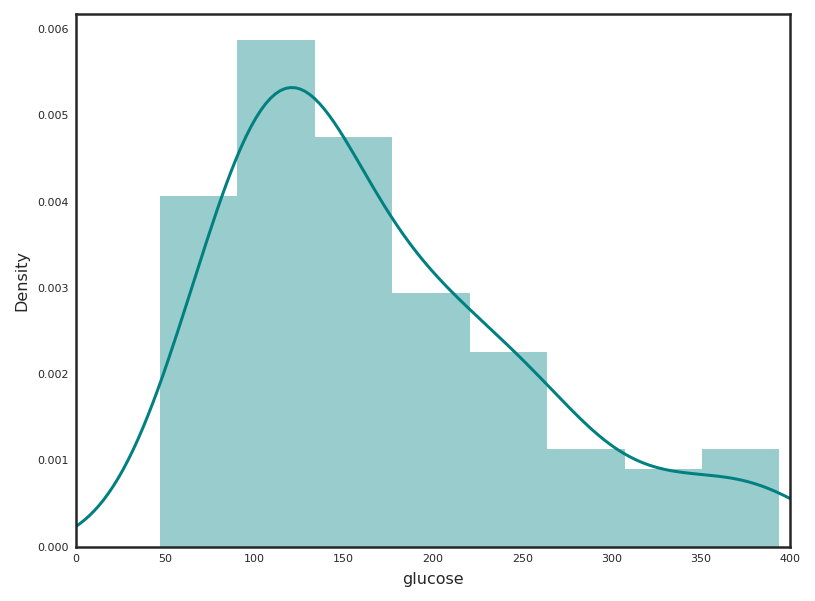

In [39]:
ax = sns.distplot(pessoas_com_diabetes.glucose, norm_hist=False)
ax.set_xlim(0,400)

(0.0, 400.0)

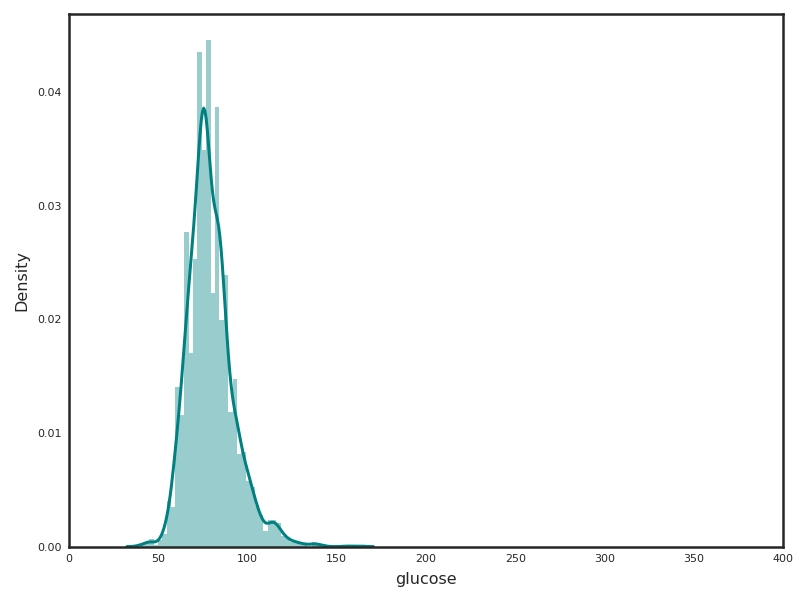

In [40]:
ax = sns.distplot(pessoas_sem_diabetes.glucose, norm_hist=False)
ax.set_xlim(0,400)

(0.0, 70.0)

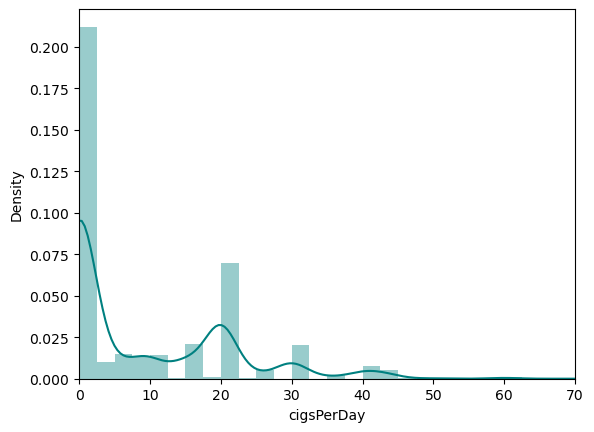

In [19]:
ax = sns.distplot(ds.cigsPerDay, norm_hist = False)
ax.set_xlim(0,70)

In [20]:
ds.currentSmoker.value_counts()

0    2084
1    2004
Name: currentSmoker, dtype: int64

<AxesSubplot:>

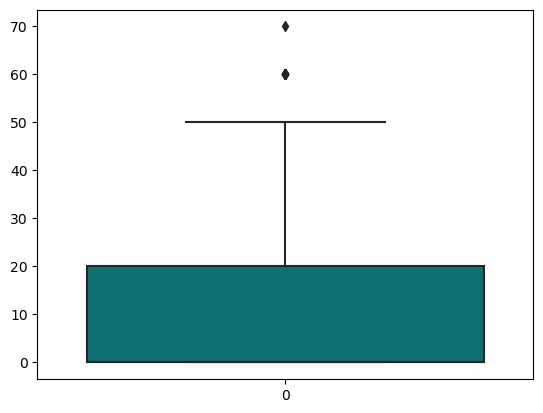

In [21]:
sns.boxplot(ds.cigsPerDay)

In [22]:
ds.cigsPerDay.mean()

8.992416829745597

0 - não fumante
1 - fumante leve (1 ate 10)
2 - fumante moderado (11 ate 20)
3 - fumante severo (+ de 20 cigarros)

In [23]:
limites = [-1, 1, 11, 20, 71]
categorias = [0,1,2,3]

In [24]:
fumante_categorico = pd.cut(ds.cigsPerDay, limites, labels = categorias)
fumante_categorico

0       0
1       0
2       2
3       3
4       3
       ..
4232    0
4233    0
4234    3
4236    2
4237    0
Name: cigsPerDay, Length: 4088, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]

In [25]:
ds = ds.assign_column('fumante_categorico', fumante_categorico)

In [26]:
ds.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,fumante_categorico
0,1,39,4.0,0,0,0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0,0
1,0,46,2.0,0,0,0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,0
2,1,48,1.0,1,20,0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0,2
3,0,61,3.0,1,30,0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1,3
4,0,46,3.0,1,23,0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0,3


In [27]:
ds.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: BinaryClassificationDataset</h3><h3>4,088 Rows, 17 Columns</h3><h4>C…

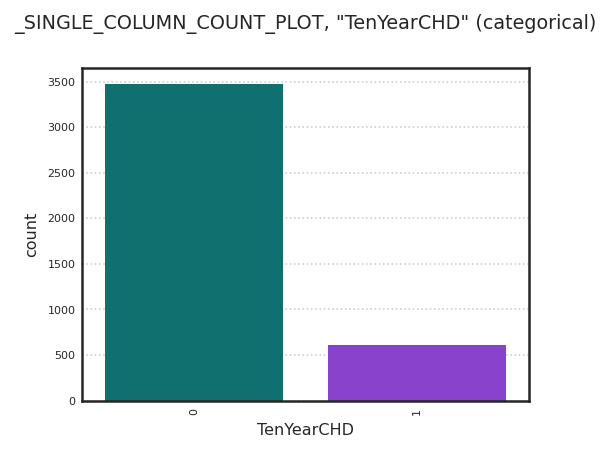

In [29]:
ds.target.show_in_notebook()